Milestone 2 - Bone Fracture Detection 
- Alexandra-Camelia Stefan 343C4
- Maria-Andreea Tudosie 343C4

Importing the needed libraries for our solution.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset, Dataset
from torchvision import datasets, transforms
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import cv2

train_directory_path = './MURA-v1.1/train'
test_directory_path = './MURA-v1.1/test'

The first step in preprocessing our dataset is checking the images properties.

First, we check if the images have the same number of channels.

In [4]:
def check_image_property_RGB(directory):
    noRGB = 0
    noL = 0
    
    # Walk through each file in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                # Check the number of channels
                if img.mode == "RGB":
                    channels = 3
                    noRGB += 1
                elif img.mode == "L":  # Grayscale
                    channels = 1
                    noL += 1
                else:
                    channels = len(img.getbands())
                

    print("----->There are", noRGB, "RGB images and", noL, "grayscale images in the directory")
    return noRGB, noL


In [5]:
print(" Checking the properties of images in the traininig directory:")
check_image_property_RGB(train_directory_path)

print("\n Checking the properties of images in the testing directory:")
check_image_property_RGB(test_directory_path)

 Checking the properties of images in the traininig directory:
----->There are 14631 RGB images and 22177 grayscale images in the directory

 Checking the properties of images in the testing directory:
----->There are 1358 RGB images and 1839 grayscale images in the directory


(1358, 1839)

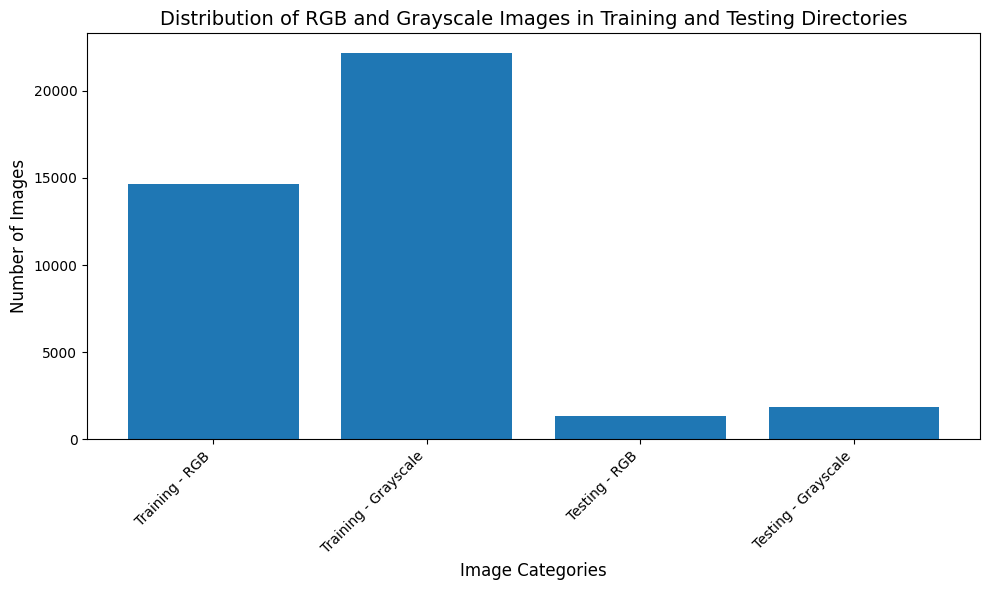

In [6]:
# Data from the provided output
categories = ['Training - RGB', 'Training - Grayscale', 'Testing - RGB', 'Testing - Grayscale']
values = [14631, 22177, 1358, 1839]
 
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(categories, values)
plt.xlabel('Image Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of RGB and Grayscale Images in Training and Testing Directories', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We verify if the images are the same size, to see if we have to resize them.

In [7]:
def get_image_sizes(directory):
    widths = []
    heights = []

    # Walk through each file in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)

    if len(set(widths)) <= 1 and len(set(heights)) <= 1:
        print("All images have the same dimention pixels.")
    else:
        print("Images have different dimentions. Widths varry between", min(widths), "and", max(widths), "pixels.")
        print("Heights varry between", min(heights), "and", max(heights), "pixels.")

In [8]:
print("Checking the sizes of images in the training directory:")
get_image_sizes(train_directory_path)

print("\nChecking the sizes of images in the testing directory:")
get_image_sizes(test_directory_path)

Checking the sizes of images in the training directory:
Images have different dimentions. Widths varry between 89 and 512 pixels.
Heights varry between 132 and 512 pixels.

Checking the sizes of images in the testing directory:
Images have different dimentions. Widths varry between 108 and 512 pixels.
Heights varry between 151 and 512 pixels.


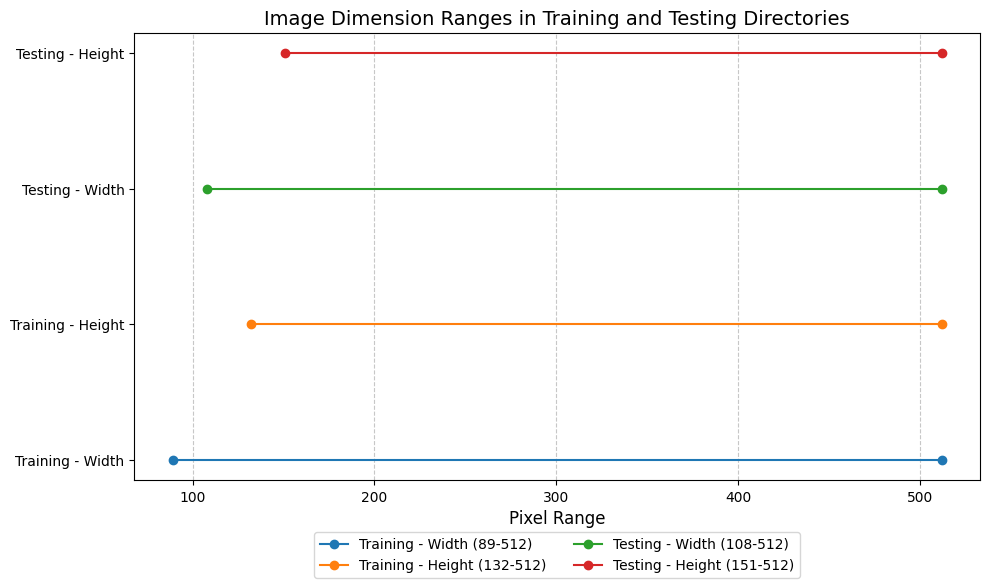

In [9]:
# Data for widths and heights in training and testing directories
categories = ['Training - Width', 'Training - Height', 'Testing - Width', 'Testing - Height']
min_values = [89, 132, 108, 151]
max_values = [512, 512, 512, 512]
 
# Plotting the ranges
plt.figure(figsize=(10, 6))
for i, category in enumerate(categories):
    plt.plot([min_values[i], max_values[i]], [i, i], marker='o', label=f'{category} ({min_values[i]}-{max_values[i]})')
 
plt.yticks(range(len(categories)), categories)
plt.xlabel('Pixel Range', fontsize=12)
plt.title('Image Dimension Ranges in Training and Testing Directories', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

We verify if the pixels have the same scale.

In [10]:
def check_image_scales(directory):
    min_value = None
    max_value = None

    # Parcurgem toate fișierele din director
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Încărcăm imaginea și o convertim într-un array numpy
            with Image.open(file_path) as img:
                img_array = np.array(img)
                
                # Calculăm valorile minime și maxime ale pixelilor pentru imaginea curentă
                current_min = img_array.min()
                current_max = img_array.max()
                
                # Setăm prima valoare min și max găsite
                if min_value is None and max_value is None:
                    min_value, max_value = current_min, current_max
                else:
                    # Verificăm dacă valorile min și max sunt consistente
                    if current_min != min_value or current_max != max_value:
                        print(f"Inconsistent scale found in image: {file}")
                        print(f"Expected range: [{min_value}, {max_value}], but got [{current_min}, {current_max}]")
                        return False, (min_value, max_value)
    
    print(f"All images are on the same scale: [{min_value}, {max_value}]")
    return True, (min_value, max_value)


In [11]:
# Exemplu de utilizare
is_consistent, value_range = check_image_scales(train_directory_path)
print("For training:")
print("Images are on the same scale:", is_consistent)
print("Interval of pixels values:", value_range)

is_consistent, value_range = check_image_scales(test_directory_path)
print("\nFor testing:")
print("Images are on the same scale:", is_consistent)
print("Interval of pixels values:", value_range)

Inconsistent scale found in image: image1.png
Expected range: [0, 255], but got [1, 183]
For training:
Images are on the same scale: False
Interval of pixels values: (0, 255)
Inconsistent scale found in image: image3.png
Expected range: [0, 255], but got [0, 250]

For testing:
Images are on the same scale: False
Interval of pixels values: (0, 255)


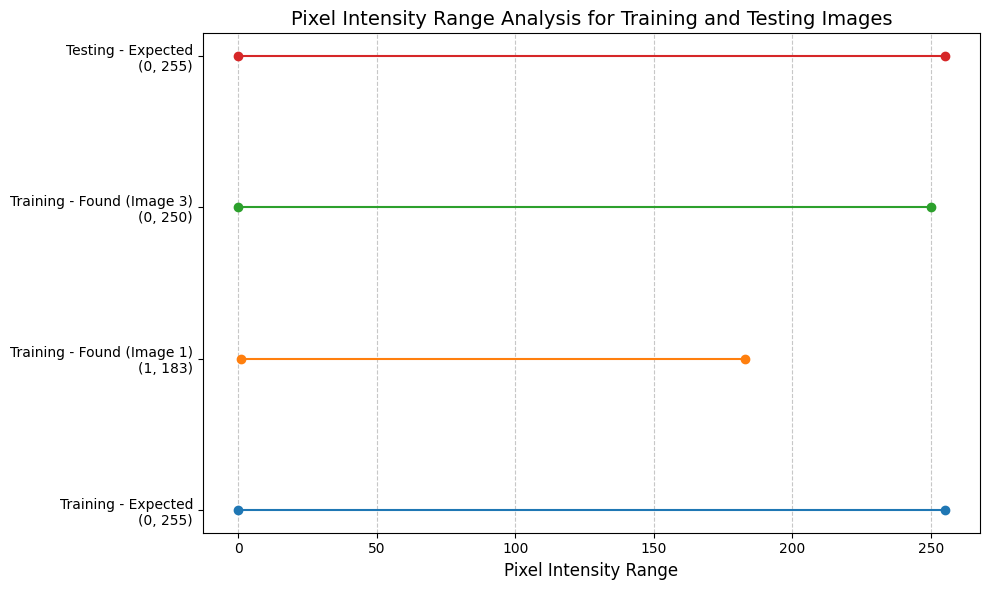

In [12]:
# Data for visualization
categories = ['Training - Expected', 'Training - Found (Image 1)', 'Training - Found (Image 3)', 'Testing - Expected']
pixel_ranges = [(0, 255), (1, 183), (0, 250), (0, 255)]
 
# Prepare labels and data for plotting
labels = [f"{cat}\n{rng}" for cat, rng in zip(categories, pixel_ranges)]
min_values = [rng[0] for rng in pixel_ranges]
max_values = [rng[1] for rng in pixel_ranges]
 
# Plotting the ranges
plt.figure(figsize=(10, 6))
for i, label in enumerate(labels):
    plt.plot([min_values[i], max_values[i]], [i, i], marker='o', label=label)
 
plt.yticks(range(len(labels)), labels)
plt.xlabel('Pixel Intensity Range', fontsize=12)
plt.title('Pixel Intensity Range Analysis for Training and Testing Images', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

I create the dataset structure.

In [15]:
class BoneFractureDataset(Dataset):
    def __init__(self, labeled_train_file, paths_file, transform=None):
        """
        Args:
            labeled_train_file (str): Fișierul CSV care conține directoarele și etichetele lor.
            paths_file (str): Fișierul care conține căile complete către imagini.
            transform (callable, optional): Transformările aplicate pe imagini.
        """
        self.transform = transform

        # Încarcă fișierele
        labeled_train = pd.read_csv(labeled_train_file, header=None, names=["directory", "label"])
        paths = pd.read_csv(paths_file, header=None, names=["image_path"])

        # Creează un dicționar pentru a lega directoarele de etichete
        self.label_dict = {os.path.normpath(row["directory"]): row["label"] for _, row in labeled_train.iterrows()}

        # Creează o listă cu imaginile și etichetele lor
        self.data = []
        for path in paths["image_path"]:
            parent_dir = os.path.normpath(os.path.dirname(path))  # Extrage directorul părinte
            if parent_dir in self.label_dict:
                self.data.append((path, self.label_dict[parent_dir]))
    
    def __len__(self):
        """Returnează numărul total de imagini."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Return an image, its label, and its file path.
        
        Args:
            idx (int): Index of the image.
        
        Returns:
            image (Tensor): Transformed image.
            label (int): Label of the image.
            img_path (str): File path of the image.
        """
        img_path, label = self.data[idx]

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

In [16]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Inițializăm dataset-ul
dataset = BoneFractureDataset(
    labeled_train_file='./MURA-v1.1/train_labeled_studies.csv',
    paths_file='./MURA-v1.1/train_image_paths.csv',
    transform=data_transforms
)

test_dataset = BoneFractureDataset(
    labeled_train_file='./MURA-v1.1/test_labeled_studies.csv',
    paths_file='./MURA-v1.1/test_image_paths.csv',
    transform=data_transforms
)

# Train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

# Initialize data loaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


Training images: 29446
Validation images: 7362
Testing images: 3197


I check if now the dataset has the same properties for all images.

In [17]:
def check_transformed_dataset(dataset):
    """
    Function to verify properties of the transformed dataset:
    - Number of channels
    - Image dimensions
    - Pixel value range
    """
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    data_iter = iter(dataloader)

    try:
        batch = next(data_iter)
        # Unpack the dataset outputs (image, label, img_path)
        if len(batch) == 3:  # If img_path is included
            images, labels, _ = batch
        else:  # Otherwise
            images, labels = batch
    except Exception as e:
        print(f"Error during dataset validation: {e}")
        return

    # Validate number of channels
    num_channels = images.shape[1]
    if num_channels != 3:
        print(f"Incorrect number of channels: {num_channels} instead of 3")
    else:
        print("Number of channels is correct (3 - RGB)")

    # Validate image dimensions
    image_height, image_width = images.shape[2], images.shape[3]
    if (image_height, image_width) != (224, 224):
        print(f"Incorrect dimensions: ({image_height}, {image_width}) instead of (224, 224)")
    else:
        print("Image dimensions are correct (256 x 256)")

    # Validate pixel value range
    min_pixel_value = images.min().item()
    max_pixel_value = images.max().item()
    print(f"Minimum pixel value: {min_pixel_value}")
    print(f"Maximum pixel value: {max_pixel_value}")

    if min_pixel_value < -1 or max_pixel_value > 1:
        print("Pixel values are outside the range [-1, 1]. Check normalization.")
    else:
        print("Pixel values are within the range [-1, 1].")


print("We check the training dataset:")
check_transformed_dataset(dataset)

print("\nWe check the testing dataset:")
check_transformed_dataset(test_dataset)


We check the training dataset:
Number of channels is correct (3 - RGB)
Image dimensions are correct (256 x 256)
Minimum pixel value: -1.0
Maximum pixel value: 1.0
Pixel values are within the range [-1, 1].

We check the testing dataset:
Number of channels is correct (3 - RGB)
Image dimensions are correct (256 x 256)
Minimum pixel value: -1.0
Maximum pixel value: 1.0
Pixel values are within the range [-1, 1].


We plot the class distribution for each dataset.

Class Distribution in Train Dataset:
  Class 1: 11923 samples
  Class 0: 17523 samples
Class Distribution in Validation Dataset:
  Class 0: 4412 samples
  Class 1: 2950 samples
Class Distribution in Test Dataset:
  Class 1: 1530 samples
  Class 0: 1667 samples


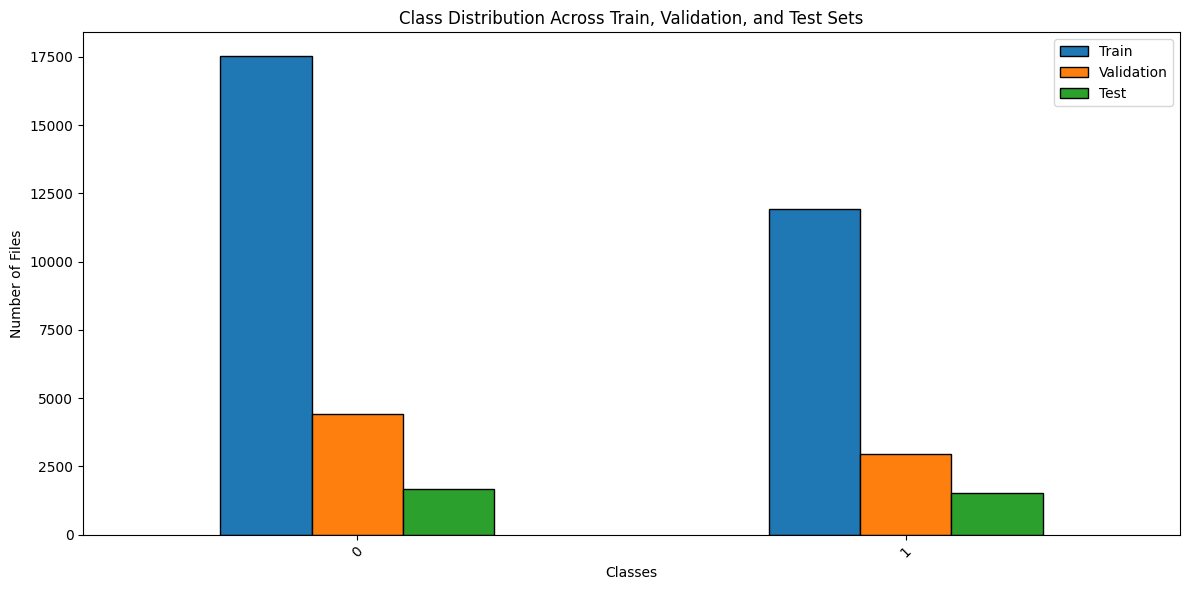

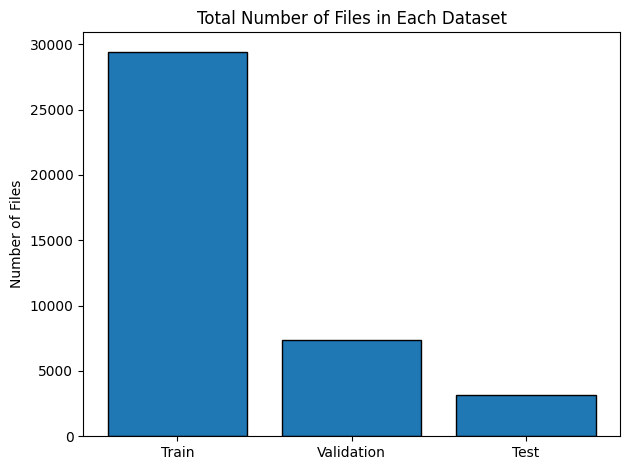

In [18]:
def analyze_dataset(dataset, dataset_name):
    """
    Analyzes the class distribution in the dataset.

    Args:
        dataset (Dataset): The dataset to analyze.
        dataset_name (str): Name of the dataset (e.g., 'Train', 'Validation', 'Test').

    Returns:
        Counter: Counts of each class.
    """
    labels = [label for _, label, _ in dataset]  # Adjusted to handle 3 outputs: image, label, img_path
    label_counts = Counter(labels)

    print(f"Class Distribution in {dataset_name} Dataset:")
    for label, count in label_counts.items():
        print(f"  Class {label}: {count} samples")

    return label_counts


def plot_class_distribution(train_counts, val_counts, test_counts):
    """
    Plots the class distribution for training, validation, and testing datasets.
    
    Args:
        train_counts (Counter): Class counts in the training dataset.
        val_counts (Counter): Class counts in the validation dataset.
        test_counts (Counter): Class counts in the testing dataset.
    """
    # Combine all class labels
    all_classes = set(train_counts.keys()).union(val_counts.keys(), test_counts.keys())
    all_classes = sorted(all_classes)

    # Prepare data for plotting
    train_values = [train_counts.get(cls, 0) for cls in all_classes]
    val_values = [val_counts.get(cls, 0) for cls in all_classes]
    test_values = [test_counts.get(cls, 0) for cls in all_classes]

    df = pd.DataFrame({
        'Train': train_values,
        'Validation': val_values,
        'Test': test_values
    }, index=all_classes)

    # Plot
    df.plot(kind='bar', figsize=(12, 6), edgecolor='black')
    plt.title("Class Distribution Across Train, Validation, and Test Sets")
    plt.xlabel("Classes")
    plt.ylabel("Number of Files")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_total_samples(train_counts, val_counts, test_counts):
    """
    Plots the total number of samples in training, validation, and testing datasets.
    
    Args:
        train_counts (Counter): Class counts in the training dataset.
        val_counts (Counter): Class counts in the validation dataset.
        test_counts (Counter): Class counts in the testing dataset.
    """
    total_files = {
        "Train": sum(train_counts.values()),
        "Validation": sum(val_counts.values()),
        "Test": sum(test_counts.values())
    }

    # Plot
    plt.bar(total_files.keys(), total_files.values(), edgecolor='black')
    plt.title("Total Number of Files in Each Dataset")
    plt.ylabel("Number of Files")
    plt.tight_layout()
    plt.show()


# Analyze datasets
train_counts = analyze_dataset(train_dataset, "Train")
val_counts = analyze_dataset(val_dataset, "Validation")
test_counts = analyze_dataset(test_dataset, "Test")

# Plot distributions
plot_class_distribution(train_counts, val_counts, test_counts)
plot_total_samples(train_counts, val_counts, test_counts)

We plot the class distribution for each dataset.

Class Distribution in Train Dataset:
  Class 0: 17520 samples
  Class 1: 11926 samples
Class Distribution in Validation Dataset:
  Class 1: 2947 samples
  Class 0: 4415 samples
Class Distribution in Test Dataset:
  Class 1: 1530 samples
  Class 0: 1667 samples


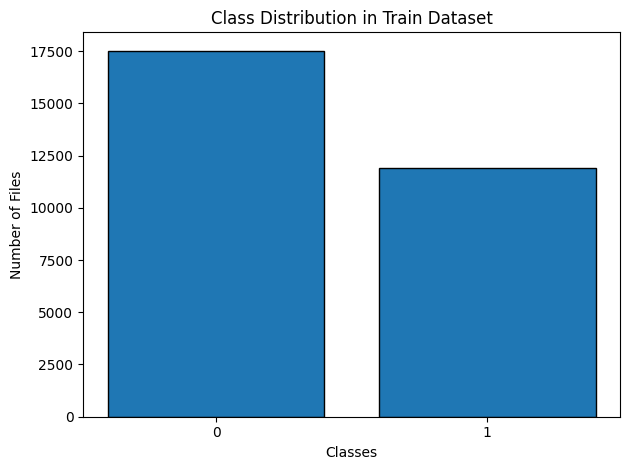

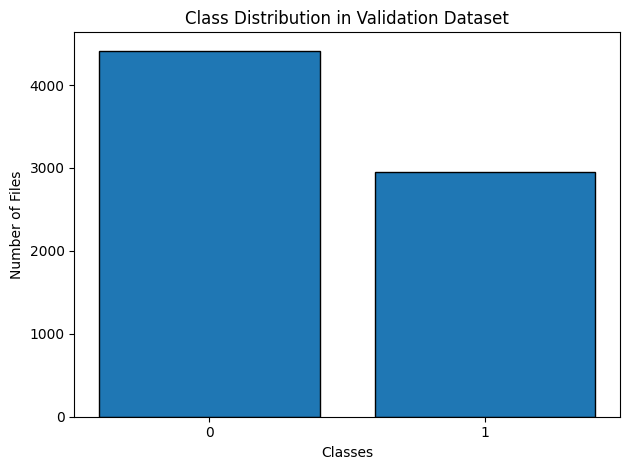

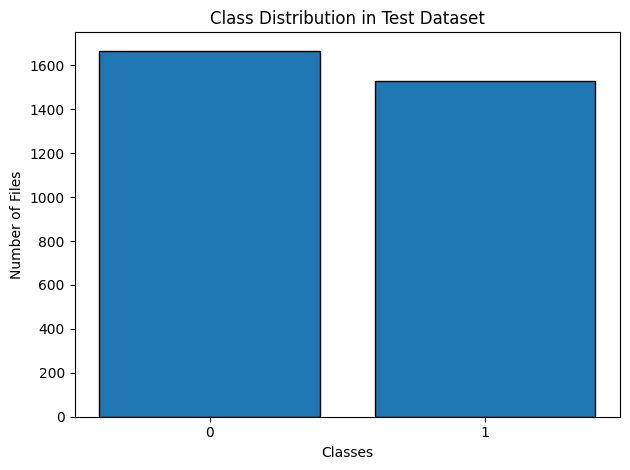

In [ ]:
def plot_class_distribution_separately_fixed_classes(label_counts, dataset_name, class_labels=[0, 1]):
    """
    Plots the class distribution for a specific dataset with fixed class labels.
    
    Args:
        label_counts (Counter): Class counts for the dataset.
        dataset_name (str): Name of the dataset (e.g., 'Train', 'Validation', 'Test').
        class_labels (list): List of class labels to ensure consistent X-axis (e.g., [0, 1]).
    """
    # Ensure all class labels are present
    counts = [label_counts.get(cls, 0) for cls in class_labels]
    
    # Plot
    plt.bar(class_labels, counts, edgecolor='black')
    plt.title(f"Class Distribution in {dataset_name} Dataset")
    plt.xlabel("Classes")
    plt.ylabel("Number of Files")
    plt.xticks(class_labels, labels=[str(cls) for cls in class_labels])  # Explicit class labels
    plt.tight_layout()
    plt.show()

# Analyze datasets
train_counts = analyze_dataset(train_dataset, "Train")
val_counts = analyze_dataset(val_dataset, "Validation")
test_counts = analyze_dataset(test_dataset, "Test")

# Plot each dataset separately with fixed class labels
plot_class_distribution_separately_fixed_classes(train_counts, "Train")
plot_class_distribution_separately_fixed_classes(val_counts, "Validation")
plot_class_distribution_separately_fixed_classes(test_counts, "Test")
